In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import torch.nn as nn

from torch.nn.functional import cosine_similarity

from torch.utils.data import Dataset, DataLoader
import pickle
import pandas as pd
import torch.optim as optim

In [ ]:
class BERTAutoencoder(nn.Module):
    def __init__(self, bert_model, hidden_size=768, latent_size=256):
        super(BERTAutoencoder, self).__init__()
        self.bert_model = bert_model
        self.encoder_fc = nn.Linear(hidden_size, latent_size)
        self.decoder_fc = nn.Linear(latent_size, hidden_size)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Ensure BERT parameters are not updated
            outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
            cls_token = outputs.last_hidden_state[:, 0, :]  # CLS token

        encoded = self.encoder_fc(cls_token)
        decoded = self.decoder_fc(encoded)
        return decoded, cls_token, encoded


In [ ]:

# Load the tokenizer and model
model_path = "/content/drive/MyDrive/Final_files/best_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
bert_model = BertModel.from_pretrained(model_path)

# Create the autoencoder model
autoencoder = BERTAutoencoder(bert_model)

# Load autoencoder weights
autoencoder_weights_path = "/content/drive/MyDrive/Final_files/Autoencoder.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder_state = torch.load(autoencoder_weights_path, map_location=device)
autoencoder.load_state_dict(autoencoder_state)

# Move the autoencoder model to the correct device
autoencoder.to(device)


BERTAutoencoder(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# prompt: import /content/drive/MyDrive/Final_files/df_with_latent.pkl as df

import pickle

# Change the path to the actual location of the pickle file on your Google Drive
with open("/content/drive/MyDrive/Final_files/df_with_cls_mapped_autoencoder.pkl", "rb") as f:
  df = pickle.load(f)


In [ ]:
df.head()

,Name,Age,Gender,Height,Weight,State,Internet_Usage,Employment_Status,Occupation,Q1,...,Q13,Q14,Q15,Disorder,Keywords,Sentence,CLS_Token,reconstructed_cls,original_cls,latent_cls
0,Bonnie Ibarra,28,Male,188,103,Kerala,Medium,Unemployed,Unemployed,Disagree,...,Agree,Disagree,Neutral,Depressive Disorders,"[Techniques, Hopelessness, Self-care]",I'm constantly tired no matter how much I sleep.,"[0.6711121, -0.16618687, 0.76495486, -0.570054...","[[tensor(0.3996), tensor(-0.3106), tensor(0.44...","[[tensor(0.6711), tensor(-0.1662), tensor(0.76...","[[tensor(0.1933), tensor(-0.0738), tensor(1.69..."
1,Jesse Horton,38,Female,110,59,Kerala,Low,Employed,"Scientist, research (medical)",Strongly Disagree,...,Strongly Disagree,Agree,Neutral,Depressive Disorders,"[Fatigue, Worthlessness, Sadness]",Nothing seems worth the effort anymore.,"[0.49055693, -0.4675204, 0.5545921, -0.5326403...","[[tensor(0.2792), tensor(-0.2454), tensor(0.50...","[[tensor(0.4906), tensor(-0.4675), tensor(0.55...","[[tensor(0.5805), tensor(-0.2675), tensor(1.62..."
2,Geoffrey Thompson,28,Female,163,68,Madhya Pradesh,Medium,Student,Master of Arts,Disagree,...,Strongly Disagree,Agree,Strongly Disagree,Obsessive-Compulsive and Related Disorders,"[Hoarding, Compulsions, Obsessions]",I have to count steps or objects to feel safe.,"[-0.9334826, 0.1029918, 1.8376131, -0.5487464,...","[[tensor(-0.8087), tensor(0.2752), tensor(2.14...","[[tensor(-0.9335), tensor(0.1030), tensor(1.83...","[[tensor(-1.5810), tensor(0.2088), tensor(-0.6..."
3,Jose Douglas,28,Male,199,93,Rajasthan,Medium,Unemployed,Unemployed,Strongly Agree,...,Neutral,Neutral,Agree,Post-Traumatic Stress Disorder (PTSD),"[Flashbacks, Re-experiencing, Self-help]",I have difficulty enjoying activities I used t...,"[0.4376393, -0.12934443, -1.2638417, -0.635943...","[[tensor(0.4627), tensor(-0.2426), tensor(-1.6...","[[tensor(0.4376), tensor(-0.1293), tensor(-1.2...","[[tensor(-0.9995), tensor(0.7045), tensor(0.03..."
4,Jennifer Whitney,30,Female,149,87,Goa,High,Unemployed,Unemployed,Agree,...,Disagree,Disagree,Strongly Agree,Attention-Deficit/Hyperactivity Disorder (ADHD),"[Organization, Inattention, Focused]",I feel like I'm always in a hurry.,"[-0.24651861, -0.2765267, -0.27644023, 0.17089...","[[tensor(-0.2318), tensor(-0.2992), tensor(-0....","[[tensor(-0.2465), tensor(-0.2765), tensor(-0....","[[tensor(0.7098), tensor(0.3692), tensor(-0.37..."


In [ ]:
df.dtypes

Name                   object
Age                     int64
Gender               category
Height                  int64
Weight                  int64
State                category
Internet_Usage       category
Employment_Status    category
Occupation             object
Q1                   category
Q2                   category
Q3                   category
Q4                   category
Q5                   category
Q6                   category
Q7                   category
Q8                   category
Q9                   category
Q10                  category
Q11                  category
Q12                  category
Q13                  category
Q14                  category
Q15                  category
Disorder             category
Keywords               object
Sentence               object
CLS_Token              object
reconstructed_cls      object
original_cls           object
latent_cls             object
dtype: object

In [ ]:
# prompt: with torch.no_grad():
#     reconstructed_cls, original_cls, latent_cls = autoencoder(inputs['input_ids'], inputs['attention_mask'])
# do this for each sentence in the df and save as a feature each , reconstructed,_cls  orignal_cls and latent cls

df["reconstructed_cls"] = [None]*len(df)  # Initialize with None for each row
df["original_cls"] = [None]*len(df)
df["latent_cls"] = [None]*len(df)

for i in range(len(df)):
    input_text = df['Sentence'][i]
    inputs = tokenizer(input_text, return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        reconstructed_cls, original_cls, latent_cls = autoencoder(inputs['input_ids'], inputs['attention_mask'])
    df["reconstructed_cls"][i] = reconstructed_cls.squeeze(0).cpu().numpy()  # Assign to the i-th element
    df["original_cls"][i] = original_cls.squeeze(0).cpu().numpy()
    df["latent_cls"][i] = latent_cls.squeeze(0).cpu().numpy()
    cosine_similarity_score = cosine_similarity(original_cls, reconstructed_cls)
    print(f"Cosine Similarity Score for Sentence {i}: {cosine_similarity_score}")

<ipython-input-13-b96374f99991>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reconstructed_cls"][i] = reconstructed_cls.squeeze(0).cpu().numpy()  # Assign to the i-th element
<ipython-input-13-b96374f99991>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["original_cls"][i] = original_cls.squeeze(0).cpu().numpy()
<ipython-input-13-b96374f99991>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["latent_cls"][i] = latent_

Streaming output truncated to the last 5000 lines.
Cosine Similarity Score for Sentence 5000: tensor([0.9563])
Cosine Similarity Score for Sentence 5001: tensor([0.9328])
Cosine Similarity Score for Sentence 5002: tensor([0.9763])
Cosine Similarity Score for Sentence 5003: tensor([0.9665])
Cosine Similarity Score for Sentence 5004: tensor([0.9335])
Cosine Similarity Score for Sentence 5005: tensor([0.9149])
Cosine Similarity Score for Sentence 5006: tensor([0.8997])
Cosine Similarity Score for Sentence 5007: tensor([0.8874])
Cosine Similarity Score for Sentence 5008: tensor([0.9053])
Cosine Similarity Score for Sentence 5009: tensor([0.9107])
Cosine Similarity Score for Sentence 5010: tensor([0.9646])
Cosine Similarity Score for Sentence 5011: tensor([0.9297])
Cosine Similarity Score for Sentence 5012: tensor([0.9043])
Cosine Similarity Score for Sentence 5013: tensor([0.9215])
Cosine Similarity Score for Sentence 5014: tensor([0.9279])
Cosine Similarity Score for Sentence 5015: tensor

In [ ]:

# # Save the modified DataFrame
with open("/content/drive/MyDrive/Final_files/df_with_cls_mapped_autoencoderv2.pkl", "wb") as f:
    pickle.dump(df, f)


In [ ]:
print("Dimenstions of CLS embedding:",df['original_cls'][0].shape)
print(df['original_cls'][0])

Dimenstions of CLS embedding: (768,)
[ 6.71113670e-01 -1.66187763e-01  7.64955997e-01 -5.70055783e-01
  1.33199096e+00  4.78293806e-01 -1.07892916e-01  3.31792653e-01
 -2.75663771e-02 -9.60000694e-01 -1.68693018e+00  1.03133965e+00
 -5.32110095e-01  2.48146191e-01 -1.11078990e+00  4.74890143e-01
  4.57828552e-01 -1.15041591e-01  3.75939310e-01  3.61844718e-01
 -4.98580277e-01  8.36767495e-01 -8.94487873e-02  2.18002379e-01
  1.12951767e+00  1.02943110e+00  4.91010323e-02 -3.86060059e-01
 -1.88965946e-01 -3.61484662e-02 -9.22941148e-01 -9.79009748e-01
  1.40205514e+00 -6.08885109e-01 -3.17938030e-02 -9.42369476e-02
  8.41406465e-01  7.55784959e-02 -7.97420979e-01  2.37110723e-02
 -1.87135905e-01 -2.66138464e-01 -1.51282638e-01 -7.73402393e-01
 -1.36604398e-01  1.40020564e-01 -1.72838271e+00  9.90514979e-02
  1.77062809e+00 -1.82745337e-01  4.06248122e-01  5.82641602e-01
 -9.88046527e-01  6.12138331e-01  4.76176202e-01 -1.49557698e+00
  5.46986520e-01 -1.06633580e+00  1.07654363e-01  1.8

In [ ]:
CLS='reconstructed_cls'

In [ ]:
def do_prediction_from_cls_token(CLS):
  class CLSTokenDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.dataframe['Disorder'] = pd.Categorical(self.dataframe['Disorder'])
        self.dataframe['Disorder'] = self.dataframe['Disorder'].cat.codes

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        cls_token = self.dataframe.iloc[idx][CLS]
        disorder = self.dataframe.iloc[idx]['Disorder']
        return torch.tensor(cls_token, dtype=torch.float32), torch.tensor(disorder, dtype=torch.long)

  train_df = df.sample(frac=0.8, random_state=42)
  temp_df = df.drop(train_df.index)
  val_df = temp_df.sample(frac=0.5, random_state=42)
  test_df = temp_df.drop(val_df.index)

  # Create datasets and dataloaders
  train_dataset = CLSTokenDataset(train_df)
  val_dataset = CLSTokenDataset(val_df)
  test_dataset = CLSTokenDataset(test_df)

  train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

  class CLSClassifier(nn.Module):
    def __init__(self, hidden_size=768, num_classes=6):
        super(CLSClassifier, self).__init__()
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, cls_token):
        x = self.dropout(cls_token)
        logits = self.fc(x)
        return logits

  # Define the model
  num_classes = df['Disorder'].nunique()
  classifier = CLSClassifier(hidden_size=768, num_classes=num_classes)
  classifier.to(device)

  # Define the optimizer and loss function
  optimizer = optim.Adam(classifier.parameters(), lr=2e-5)
  criterion = nn.CrossEntropyLoss()

  # Training loop
  epochs = 50
  classifier.train()

  for epoch in range(epochs):
      epoch_loss = 0
      correct = 0
      total = 0

      for cls_tokens, labels in train_loader:
          cls_tokens, labels = cls_tokens.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = classifier(cls_tokens)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      accuracy = 100 * correct / total
      avg_epoch_loss = epoch_loss / len(train_loader)
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss}, Accuracy: {accuracy}%")

      # Validation
      classifier.eval()
      val_loss = 0
      correct = 0
      total = 0

      with torch.no_grad():
          for cls_tokens, labels in val_loader:
              cls_tokens, labels = cls_tokens.to(device), labels.to(device)
              outputs = classifier(cls_tokens)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      val_accuracy = 100 * correct / total
      avg_val_loss = val_loss / len(val_loader)
      print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}%")
      classifier.train()

  classifier.eval()

  test_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
      for cls_tokens, labels in test_loader:
          cls_tokens, labels = cls_tokens.to(device), labels.to(device)
          outputs = classifier(cls_tokens)
          loss = criterion(outputs, labels)
          test_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  test_accuracy = 100 * correct / total
  avg_test_loss = test_loss / len(test_loader)
  print(f"Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}%")


  model_save_path = f"/content/drive/MyDrive/Final_files/{CLS}_Classifier.pt"
  torch.save(classifier.state_dict(), model_save_path)
  print(f"Model weights saved to {model_save_path}")

In [ ]:
classifier = do_prediction_from_cls_token(CLS)

Epoch 1/50, Loss: 1.0540004630684852, Accuracy: 78.1875%
Validation Loss: 0.6072418297094012, Validation Accuracy: 92.1%
Epoch 2/50, Loss: 0.4302055775523186, Accuracy: 93.5125%
Validation Loss: 0.3566583475423238, Validation Accuracy: 92.2%
Epoch 3/50, Loss: 0.2911189062446356, Accuracy: 93.6875%
Validation Loss: 0.2812858447432518, Validation Accuracy: 92.4%
Epoch 4/50, Loss: 0.24283420111238957, Accuracy: 93.65%
Validation Loss: 0.2481259692992483, Validation Accuracy: 92.4%
Epoch 5/50, Loss: 0.21718153356760742, Accuracy: 93.85%
Validation Loss: 0.22893989594682815, Validation Accuracy: 92.9%
Epoch 6/50, Loss: 0.20193993122503162, Accuracy: 94.1%
Validation Loss: 0.21557225186436896, Validation Accuracy: 92.9%
Epoch 7/50, Loss: 0.19100692757219076, Accuracy: 94.15%
Validation Loss: 0.2054550289693806, Validation Accuracy: 93.0%
Epoch 8/50, Loss: 0.1829783562347293, Accuracy: 94.3625%
Validation Loss: 0.19690153082566603, Validation Accuracy: 93.3%
Epoch 9/50, Loss: 0.17577125185728

In [ ]:
class CLSTokenDataset(Dataset):
  def __init__(self, dataframe):
      self.dataframe = dataframe
      self.dataframe['Disorder'] = pd.Categorical(self.dataframe['Disorder'])
      self.dataframe['Disorder'] = self.dataframe['Disorder'].cat.codes

  def __len__(self):
      return len(self.dataframe)

  def __getitem__(self, idx):
      cls_token = self.dataframe.iloc[idx][CLS]
      disorder = self.dataframe.iloc[idx]['Disorder']
      return torch.tensor(cls_token, dtype=torch.float32), torch.tensor(disorder, dtype=torch.long)

In [ ]:
class CLSClassifier(nn.Module):
  def __init__(self, hidden_size=768, num_classes=6):
      super(CLSClassifier, self).__init__()
      self.fc = nn.Linear(hidden_size, num_classes)
      self.dropout = nn.Dropout(0.1)

  def forward(self, cls_token):
      x = self.dropout(cls_token)
      logits = self.fc(x)
      return logits

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
CLS= 'original_cls'

In [ ]:

# Load the saved model
model_path = "/content/drive/MyDrive/Final_files/CLSClassfier.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clsclassifier = CLSClassifier(hidden_size=768, num_classes=6)
clsclassifier.load_state_dict(torch.load(model_path, map_location=device))
clsclassifier.to(device)

# Create a dataloader for the test set
test_df = df.sample(frac=0.2, random_state=42)
test_dataset = CLSTokenDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
clsclassifier.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for cls_tokens, labels in test_loader:
        cls_tokens, labels = cls_tokens.to(device), labels.to(device)
        outputs = clsclassifier(cls_tokens)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}%")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Final_files/CLSClassfier.pt'

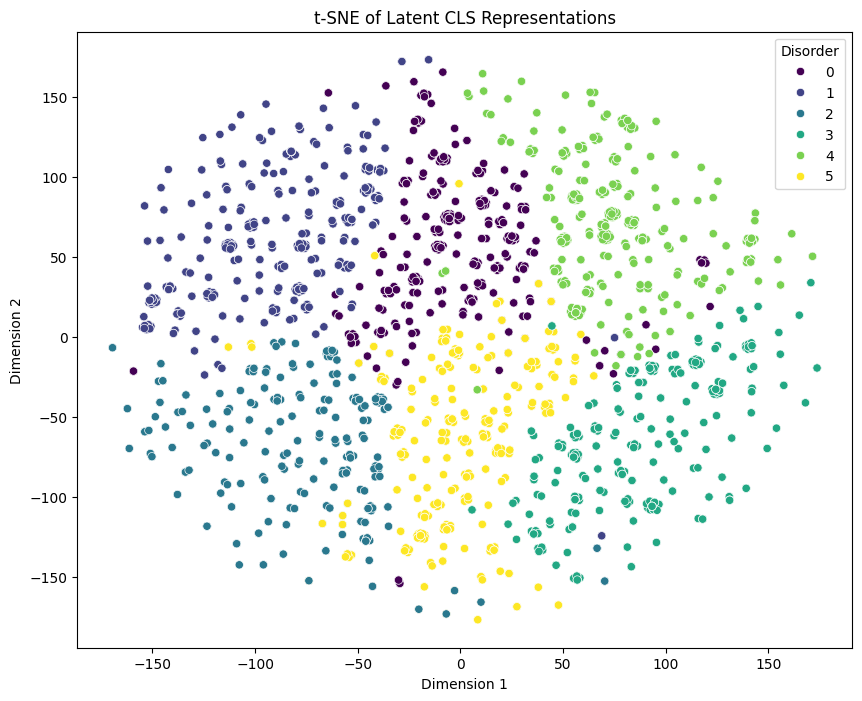

In [ ]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Ensure the disorder labels are categorical and convert to integer codes
df['Disorder'] = pd.Categorical(df['Disorder'])
df['Disorder'] = df['Disorder'].cat.codes

# Extract the latent_cls and disorder labels
latent_cls = np.stack(df['latent_cls'].values)
labels = df['Disorder'].values

# Apply t-SNE to reduce latent_cls to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_cls)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame(latent_2d, columns=['Dim1', 'Dim2'])
tsne_df['Disorder'] = labels

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dim1', y='Dim2', hue='Disorder', palette='viridis', data=tsne_df)
plt.title('t-SNE of Latent CLS Representations')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Disorder')
plt.show()


In [ ]:
df.dtypes

Name                   object
Age                     int64
Gender               category
Height                  int64
Weight                  int64
State                category
Internet_Usage       category
Employment_Status    category
Occupation             object
Q1                   category
Q2                   category
Q3                   category
Q4                   category
Q5                   category
Q6                   category
Q7                   category
Q8                   category
Q9                   category
Q10                  category
Q11                  category
Q12                  category
Q13                  category
Q14                  category
Q15                  category
Disorder             category
Keywords               object
Sentence               object
CLS_Token              object
reconstructed_cls      object
original_cls           object
latent_cls             object
dtype: object